In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from datetime import datetime
import os
import sys
from glob import glob
from jupyterthemes import jtplot
from utils import plot_confusion_matrix
jtplot.style(theme='monokai', context='notebook', ticks=True)

In [4]:
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                      saturation=0.2, hue=0.2),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
])

In [5]:
# Load the datasets
train_data = torchvision.datasets.CIFAR10('.', train=True, 
                                          transform=transforms_train, 
                                          download=True)


test_data = torchvision.datasets.CIFAR10('.', train=False,
                                        transform=transforms.ToTensor(),
                                        download=True)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
batch_size=128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=False)

In [7]:
# Create the CNN model
class CNN(nn.Module):
    
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, padding=1), 
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2))
        
        self.conv3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(128),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(128),
                nn.MaxPool2d(2))
        
        self.dense = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(128*4*4, 1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, n_classes))
        
    
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = X.view(-1, 128*4*4)
        X = self.dense(X)
        
        return X

In [8]:
n_classes = len(set(train_data.targets))
model = CNN(n_classes)

In [9]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [10]:
# Define Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [11]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    
    """
    ------------------------------------------------
    Description : Computes the batch gradient descent
                  on the data based on the given model
                  
    
    Parameters:
    model -- a pytorch model
    criterion -- a pytorch loss function
    optimizer -- a pytorch optimizer 
    train_loader -- a pytorch data loader representing train data
    test_loader -- a pytorch data loader representing test data
    epochs -- an integer representing the number of epochs
    
    
    Return:
    train_losses -- a numpy array representing overall losses (training)
    test_losses -- a numpy array representing overall losses(testing)
    
    Usage :
    train_loss, test_loss = batch_gd(model, criterion, optimizer, train_loader,
                                    test_loader, epochs=100)
    ---------------------------------------------------
    """
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        t0 = datetime.now()
        
        train_loss = []
        for inputs, targets in train_loader:
            
            # Transfer data to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Intialize zero-grad for the optimizer
            optimizer.zero_grad()
            
            # Forward prop
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            #Backward and optimize
            loss.backward()
            optimizer.step()
            
            # Track the loss 
            train_loss.append(loss.item())
            
        
        test_loss = []
        for inputs, targets in test_loader:
            
            # Transfer the target to the device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track the loss
            test_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        test_loss = np.mean(test_loss)
        
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        
        print("Epoch : {}/{} | Train Loss : {:.4f} | Test Loss : {:.4f} | Time : {}".format(epoch+1, epochs,
                                                                                           train_loss, 
                                                                                           test_loss,
                                                                                           datetime.now()-t0))
        
    return train_losses, test_losses
            

In [12]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader,
                                    test_loader, epochs=20)


Epoch : 1/20 | Train Loss : 1.4262 | Test Loss : 1.0479 | Time : 0:01:35.099076
Epoch : 2/20 | Train Loss : 1.0155 | Test Loss : 0.8376 | Time : 0:01:32.884227
Epoch : 3/20 | Train Loss : 0.8676 | Test Loss : 0.7698 | Time : 0:01:26.859190
Epoch : 4/20 | Train Loss : 0.7865 | Test Loss : 0.6773 | Time : 0:01:20.757439
Epoch : 5/20 | Train Loss : 0.7296 | Test Loss : 0.6490 | Time : 0:01:19.622695
Epoch : 6/20 | Train Loss : 0.6952 | Test Loss : 0.6246 | Time : 0:01:30.654006
Epoch : 7/20 | Train Loss : 0.6580 | Test Loss : 0.6132 | Time : 0:01:28.408451
Epoch : 8/20 | Train Loss : 0.6346 | Test Loss : 0.5978 | Time : 0:01:28.665282
Epoch : 9/20 | Train Loss : 0.6078 | Test Loss : 0.5845 | Time : 0:01:28.375529
Epoch : 10/20 | Train Loss : 0.5870 | Test Loss : 0.5674 | Time : 0:01:29.378916
Epoch : 11/20 | Train Loss : 0.5620 | Test Loss : 0.5381 | Time : 0:01:26.854856
Epoch : 12/20 | Train Loss : 0.5484 | Test Loss : 0.5326 | Time : 0:01:28.809656
Epoch : 13/20 | Train Loss : 0.5310 |

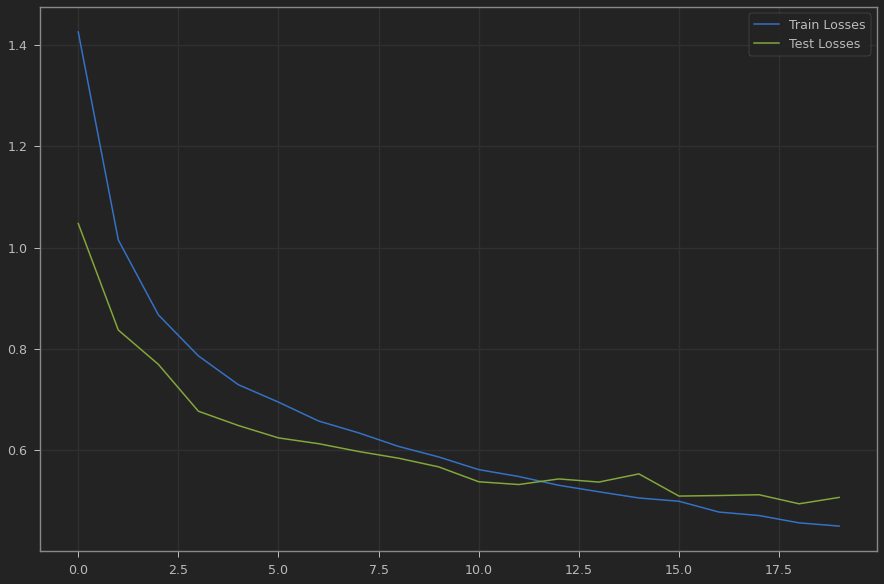

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Losses")
plt.plot(test_losses, label="Test Losses")
plt.legend()
plt.show()

In [14]:
def calculate_accuracy(loader):
    
    
    n_correct = 0
    n_total = 0

    for inputs, targets in train_loader:

        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]
        
    
    return n_correct / n_total


train_acc = calculate_accuracy(train_loader)
test_acc = calculate_accuracy(test_loader)

print("Train accuracy : {:.4f} || Test accuracy : {:.4f}".format(train_acc,
                                                                test_acc))

Train accuracy : 0.8542 || Test accuracy : 0.8529


Confusion matrix, without normalization
[[898   5  17   8  12   3   6  10  31  10]
 [ 10 938   1   0   1   0   3   1   5  41]
 [ 61   3 747  43  54  38  29  19   3   3]
 [ 19   2  46 642  54 132  46  38   8  13]
 [ 11   1  39  26 820  16  25  56   6   0]
 [  3   0  22  86  40 790  18  36   2   3]
 [ 10   7  19  29  18  18 882   8   6   3]
 [ 14   0  12  19  25  23   3 902   1   1]
 [ 53  11   5   5   1   1   3   8 892  21]
 [ 18  36   3   7   2   3   6   7  11 907]]


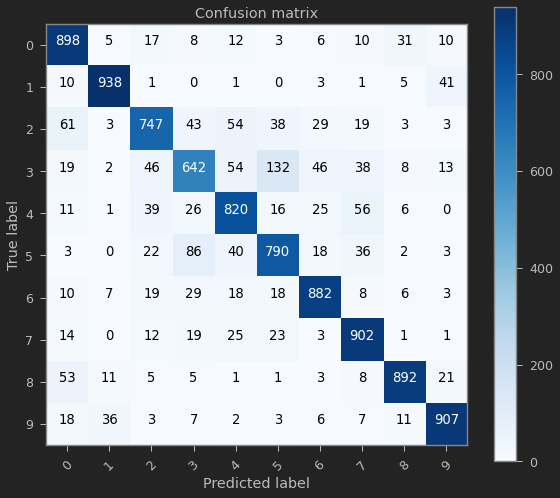

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

x_test = test_data.data
y_test = np.array(test_data.targets)
p_test = np.array([])

for inputs, targets in test_loader:
    
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
plt.grid(b=False)
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(n_classes)))
    

In [16]:
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split('\n')

Text(0.5, 1.0, 'Original Label bird || Predicted label : cat')

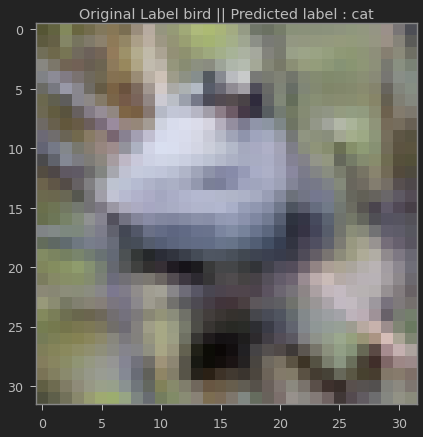

In [17]:
# Some of the misclassified examples
plt.grid(b=False)
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32, 32, 3))
plt.title("Original Label {} || Predicted label : {}".format(labels[y_test[i]], labels[p_test[i]]))

In [18]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6